In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Program name

AS_flexi_FR_PR_TTL_V2

### Variable Definitions

- D   = event time stamp
- E   = event identity stamp

### Event Stamps

#### Trial bits
- 42 - Right cue light active
- 43 - Left cue light active
- 44 - Right cue light off
- 45 - Left cue light off
- 12 - Intertrial interval begins
- 13 - Intertrial interval over and reinforcement available again
- 100 - End of session marker

#### Non-ITI bits
- 3  - Non-ITI Left lever press
- 4  - Non-ITI Right lever press
- 7  - Non-ITI Head entry
- 17 - Pellet delivery

#### ITI bits
- 10 - ITI Right lever press
- 11 - ITI Left lever press
- 14 - ITI Head entry

#### remainder
- 5  - Reinforced left lever press
- 6  - Reinforced right lever press
- 8  - Non-ITI Right nose poke
- 9  - Non-ITI Left nose poke
- 15 - ITI Right nose-poke
- 16 - ITI Left nose-poke
- 18 - Tone delivery
- 40 - PR reset lever pressed (right)
- 41 - PR reset lever pressed (left)
- 46 - Right lever extends
- 47 - Left lever extends
- 48 - Right lever retracts
- 49 - Left lever retracts
- 50 - Head entry to initiate trial
- 51 - Start time-out
- 52 - End time-out
- 53 - On houselight
- 54 - Off Houselight


In [2]:
def get_file_info_common(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    session = int(file_path_name.split('/')[-1].split('_')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, session, animal, date

In [3]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(event_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        elif re.search(time_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                i = i + 1
        else:
            i = i + 1

    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [5]:
def get_trial_times_LPD(events_and_times, trial_start_list, trial_end_list):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for start and end of trial segment
    #e.g. session onset and offset, ITI onset and offset - here both levers extend so can just use right lever as start
    #finds time_stamps for each start and end, puts into new dataframe
    import numpy as np
    import pandas as pd

    session_start_times = list(events_and_times[events_and_times['event_stamp'].isin(trial_start_list)]['time_stamp'].drop_duplicates().values)
    session_end_times = list(events_and_times[events_and_times['event_stamp'].isin(trial_end_list)]['time_stamp'].drop_duplicates().values)
    ITI_start_times = list(events_and_times[events_and_times['event_stamp'].isin(trial_end_list)]['time_stamp'].drop_duplicates().values + 0.01)
    ITI_end_times = list(events_and_times[events_and_times['event_stamp'].isin(trial_start_list)]['time_stamp'].drop_duplicates()[1:].values - 0.01)
    
    times = pd.DataFrame(data = [session_start_times, session_end_times, ITI_start_times, ITI_end_times])
    times = times.T
    times.columns = ['trial_start', 'trial_end', 'ITI_start', 'ITI_end']
    
    return times

In [6]:
def create_trial_df(events_and_times, trial_times, trial_type):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    if trial_type == 'ITI':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['ITI_start'][i]) & (events_and_times['time_stamp'] <= trial_times['ITI_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['ITI_start'] = trial_times['ITI_start'][i]
            data['ITI_end'] = trial_times['ITI_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    elif trial_type == 'within':
        while i < len(trial_times):
            data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i])]
            data['trial_#'] = [i]*len(data)
            data['trial_start'] = trial_times['trial_start'][i]
            data['trial_end'] = trial_times['trial_end'][i]
            trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
            i = i + 1
    
    return trial_data

In [7]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [8]:
def latency(trial_data, event_num, trial_type):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_ave.append(np.nan)
        else:
            if trial_type == 'ITI':
                latency_1st.append((data['time_stamp'] - data['ITI_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['ITI_start']).values.mean()/100)
            elif trial_type == 'within':
                latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
                latency_ave.append((data['time_stamp'] - data['trial_start']).values.mean()/100)
        i = i + 1
    
    return latency_1st, latency_ave

In [9]:
def create_session_df(trial_data, event_dic, trial_type):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    if trial_type == 'ITI':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['ITI_start'].unique(), trial_data.groupby('trial_#')['ITI_end'].unique()])
        times_df = times_df.T
    elif trial_type == 'within':
        times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
        times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        if trial_type == 'ITI':
            trial_time = (times_df.iloc[i]['ITI_end'] - times_df.iloc[i]['ITI_start'])/100
        elif trial_type == 'within':
            trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_ave')] = latency(trial_data, event, trial_type)
    
    #add bin cout (6 bins of 10 min each)
    if trial_type == 'ITI':
        session_data['trial_bin'] = pd.cut(times_df['ITI_end'].str[0].values/100, bins=6, labels=False)
    elif trial_type == 'within':
        session_data['trial_bin'] = pd.cut(times_df['trial_end'].str[0].values/100, bins=6, labels=False)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

### Read in animal meta data

In [10]:
#read animal info (lever assignment, group etc) into df

path_animal_info = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/round12_meta.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

print(animal_info.shape)
animal_info.head()

(65, 4)


,animal,cage,group,lever
0,1215,SA319,4,right
1,1216,SA319,4,right
2,1217,SA319,4,right
3,1236,SA326,5,right
4,1237,SA326,5,right


### Get file paths

In [11]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[-1]

543
543


'/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/PR1_1_832_200226'

### Process trial data

In [12]:
%%time
final_data = pd.DataFrame()

bit_dic = {'reinforcement': 17, 'right_lever': 4, 'left_lever': 3, 'HE': 7}
ITI_dic = {'reinforcement': 17, 'right_lever': 10, 'left_lever': 11, 'HE': 14}

for file in file_paths:

    print(file) 
    
    if file.split('/')[-1] == '.DS_Store':
        continue
    
    #proccess file
    task, session, animal, date = get_file_info_common(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E:", "D:")
    trial_times = get_trial_times_LPD(events_and_times, [46,47], [48,49])
    trial_data = create_trial_df(events_and_times, trial_times, 'within')
    ITItrial_data = create_trial_df(events_and_times, trial_times, 'ITI')
    session_data = create_session_df(trial_data, bit_dic, 'within')
    ITIsession_data = create_session_df(ITItrial_data, ITI_dic, 'ITI')
    
    #get animal metadata
    active_lever = animal_info[animal_info['animal'] == int(animal)]['lever'].iloc[0]
    group = int(animal_info[animal_info['animal'] == int(animal)]['group'])
    cage = animal_info[animal_info['animal'] == int(animal)]['cage'].iloc[0]
    
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])
    session_data['part'] = ['within']*(session_data.shape[0]) 
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal'] = [animal]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['active_lever'] = [active_lever]*(session_data.shape[0])
    session_data['group'] = [group]*(session_data.shape[0])
    session_data['cage'] = [cage]*(session_data.shape[0])
    
    session_data = session_data[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                 'trial_num', 'trial_bin', 'trial_duration', 'reinforcement_count', 'reinforcement_latency_1st', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'reinforcement_latency_ave', 'right_lever_latency_ave', 'left_lever_latency_ave']]
    
    #create pandas tidy df for within ITI
    ITIsession_data['task'] = [task]*(ITIsession_data.shape[0]) 
    ITIsession_data['part'] = ['ITI']*(ITIsession_data.shape[0]) 
    ITIsession_data['date'] = [date]*(ITIsession_data.shape[0])
    ITIsession_data['animal'] = [animal]*(ITIsession_data.shape[0])
    ITIsession_data['session'] = [session]*(ITIsession_data.shape[0])
    ITIsession_data['active_lever'] = [active_lever]*(ITIsession_data.shape[0])
    ITIsession_data['group'] = [group]*(ITIsession_data.shape[0])
    ITIsession_data['cage'] = [cage]*(ITIsession_data.shape[0])
    
    ITIsession_data = ITIsession_data[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                 'trial_num', 'trial_bin', 'trial_duration', 'reinforcement_count', 'reinforcement_latency_1st', 
                                 'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                 'right_lever_count', 'right_lever_latency_1st',
                                 'left_lever_count', 'left_lever_latency_1st',
                                 'reinforcement_latency_ave', 'right_lever_latency_ave', 'left_lever_latency_ave']]

    #add to final data frame
    data_int = pd.concat([session_data, ITIsession_data], axis = 0, ignore_index=True)
    if final_data.shape[0] == 0:
        final_data = data_int
    else:
        final_data = pd.concat([final_data, data_int], axis = 0, ignore_index=True)

final_data.tail()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_3_835_200318
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_4_827_200222
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_4_840_200319
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_3_841_200221
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_4_839_200222
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_3_1219_210408
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_6_833_200224
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_6_842_200224
/Users/abbieschindler/Documents/Schindler_Lab/Data/Beh

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_1_831_200316
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_6_835_200321
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_5_1232_190321
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDRDD_1_1226_210416
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/RDP_1_832_200323
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_1_834_200219
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDRDD_1_1249_210416
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_6_827_200321
/Users/abbieschindler/Documents/Schindler_Lab/D

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_2_835_200220
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_4_1243_210409
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_2_830_200317
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_5_834_200320
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_4_1225_210318
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_5_1226_210319
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDRC_1_1250_210414
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/PR13_1_827_200228
/Users/abbieschindler/Documents/Schindler_Lab/Da

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_2_1224_210407
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_3_1248_210408
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_6_1242_210413
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_1_1224_210315
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_1_1232_210406
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/RCP_1_828_200322
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/PR1_1_842_200226
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_5_1229_210412
/Users/abbieschindler/Documents/Schindler_Lab

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_5_833_200320
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDRC_1_1249_210414
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_5_1242_210319
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_2_837_200317
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_2_832_200220
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_4_1244_210409
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_4_1227_210409
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_5_829_200223
/Users/abbieschindler/Documents/Schindler_Lab/Da

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_5_1230_210412
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_1_1248_210406
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_6_1226_210413
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/PR1_1_834_200226
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_2_1231_210407
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_1_1231_210315
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_1_1244_210406
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_2_1249_210316
/Users/abbieschindler/Documents/Schindler_La

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDPRR1_1_1229_210401
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_4_828_200319
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_6_1218_210413
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_3_837_200221
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_4_836_200319
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_6_826_200224
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_2_1218_210316
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_3_829_200221
/Users/abbieschindler/Documents/Schindler_Lab/Da

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/FR1_1_842_200219
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDE_4_1219_210409
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/RDP_1_839_200323
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPDRDD_1_1250_210416
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/RDP_1_827_200323
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/EXT_5_825_200320
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/PR13_1_828_200228
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/reward_learning_tc/round12/all/LPD_6_1232_210322
/Users/abbieschindler/Documents/Schindler_Lab/Da

,task,part,date,session,cage,animal,group,active_lever,trial_num,trial_bin,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_count,HE_latency_1st,HE_latency_ave,right_lever_count,right_lever_latency_1st,left_lever_count,left_lever_latency_1st,reinforcement_latency_ave,right_lever_latency_ave,left_lever_latency_ave
47999,PR1,ITI,200226,1,SA160,832,4,left,9,1,29.9998,0,NaN,2,1.1199,13.6399,0,NaN,0,NaN,NaN,NaN,NaN
48000,PR1,ITI,200226,1,SA160,832,4,left,10,1,29.9998,0,NaN,1,1.3899,1.3899,0,NaN,1,0.0899,NaN,NaN,0.0899
48001,PR1,ITI,200226,1,SA160,832,4,left,11,2,29.9998,0,NaN,4,1.6599,14.0349,0,NaN,0,NaN,NaN,NaN,NaN
48002,PR1,ITI,200226,1,SA160,832,4,left,12,3,29.9998,0,NaN,1,0.6799,0.6799,0,NaN,1,0.1999,NaN,NaN,0.1999
48003,PR1,ITI,200226,1,SA160,832,4,left,13,5,29.9998,0,NaN,2,0.9799,1.0499,0,NaN,0,NaN,NaN,NaN,NaN


In [13]:
#make new df with combined data
df_final = final_data.copy()

lp_train_df_trial = pd.DataFrame()

animals = df_final['animal'].unique()

for animal in animals:
    
    #get animal data
    animal_data = df_final[df_final['animal'] == animal]
    
    #generate session df
    sessions = animal_data['session'].unique()
    
    for session in sessions:
        #get session data for animal
        animal_data_session = animal_data[animal_data['session'] == session]
        
        #compute and fill session data
        if animal_data_session['active_lever'].unique() == 'right':
            animal_data_session['active_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']

        elif animal_data_session['active_lever'].unique() == 'left':
            animal_data_session['active_lever_count'] = animal_data_session['left_lever_count']
            animal_data_session['active_lever_latency_1st'] = animal_data_session['left_lever_latency_1st']
            animal_data_session['active_lever_latency_ave'] = animal_data_session['left_lever_latency_ave']
            animal_data_session['inactive_lever_count'] = animal_data_session['right_lever_count']
            animal_data_session['inactive_lever_latency_1st'] = animal_data_session['right_lever_latency_1st']
            animal_data_session['inactive_lever_latency_ave'] = animal_data_session['right_lever_latency_ave']
            
        lp_train_df_trial = lp_train_df_trial.append(animal_data_session)
        
lp_train_df_trial.reset_index(inplace=True, drop=True)    

lp_train_df_trial = lp_train_df_trial[['task', 'part', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                       'trial_num', 'trial_bin', 'trial_duration',
                                       'reinforcement_count', 'reinforcement_latency_1st',
                                       'HE_count', 'HE_latency_1st', 'HE_latency_ave',
                                       'active_lever_count', 'active_lever_latency_1st',
                                       'inactive_lever_count', 'inactive_lever_latency_1st', 
                                       'active_lever_latency_ave', 'inactive_lever_latency_ave', 'reinforcement_latency_ave']]

lp_train_df_trial['lever_ratio'] = lp_train_df_trial['active_lever_count'] / (lp_train_df_trial['active_lever_count'] + lp_train_df_trial['inactive_lever_count'])

print(lp_train_df_trial.shape)

lp_train_df_trial.head()

(48004, 24)


,task,part,date,session,cage,animal,group,active_lever,trial_num,trial_bin,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_count,HE_latency_1st,HE_latency_ave,active_lever_count,active_lever_latency_1st,inactive_lever_count,inactive_lever_latency_1st,active_lever_latency_ave,inactive_lever_latency_ave,reinforcement_latency_ave,lever_ratio
0,EXT,within,200318,3,SA161,835,5,right,0,0,118.75,0,NaN,8,100.32,107.30625,0,NaN,1,118.74,NaN,118.74,NaN,0.0
1,EXT,within,200318,3,SA161,835,5,right,1,0,24.46,0,NaN,1,14.43,14.43000,1,20.24,1,24.45,20.24,24.45,NaN,0.5
2,EXT,within,200318,3,SA161,835,5,right,2,0,20.55,0,NaN,0,NaN,NaN,0,NaN,1,20.54,NaN,20.54,NaN,0.0
3,EXT,within,200318,3,SA161,835,5,right,3,0,0.46,0,NaN,0,NaN,NaN,0,NaN,1,0.45,NaN,0.45,NaN,0.0
4,EXT,within,200318,3,SA161,835,5,right,4,0,27.60,0,NaN,2,25.73,25.78000,1,1.80,1,27.59,1.80,27.59,NaN,0.5


In [15]:
lp_train_df_trial = lp_train_df_trial.replace({'FR1': 'LPD', 'PR1': 'LPDPRR1', 'PR13': 'LPDPRR3', 'EXT': 'LPDE', 'RCP': 'LPDRC', 'RDP': 'LPDRDD'})

### Process session data

In [42]:
#groupby session
sum_params = ['reinforcement_count', 'HE_count', 'active_lever_count', 'inactive_lever_count']
final_data_sum = lp_train_df_trial.groupby(['task', 'part', 'session', 'date', 'cage', 'animal', 'group', 'active_lever'])[sum_params].sum().reset_index()

mean_params = ['reinforcement_latency_1st', 
               'HE_latency_1st', 'HE_latency_ave', 
               'active_lever_latency_1st', 'inactive_lever_latency_1st', 
               'lever_ratio', 'trial_duration']
final_data_mean = lp_train_df_trial.groupby(['task', 'part', 'session', 'date', 'cage', 'animal', 'group', 'active_lever'])[mean_params].mean().reset_index()

final_data_max = lp_train_df_trial.groupby(['task', 'part', 'session', 'date', 'cage', 'animal', 'group', 'active_lever'])['trial_num'].max().reset_index()

final_session_data = final_data_sum.merge(final_data_mean, on=['task', 'part', 'session', 'date', 'cage', 'animal', 'group', 'active_lever'])
final_session_data['max_trial'] = final_data_max['trial_num']
print(final_session_data.shape)
final_session_data.head()

(1086, 20)


,task,part,session,date,cage,animal,group,active_lever,reinforcement_count,HE_count,active_lever_count,inactive_lever_count,reinforcement_latency_1st,HE_latency_1st,HE_latency_ave,active_lever_latency_1st,inactive_lever_latency_1st,lever_ratio,trial_duration,max_trial
0,LPD,ITI,1,200219,SA158,825,4,right,0,10,0,0,NaN,13.312400,16.626567,NaN,NaN,NaN,29.9998,4
1,LPD,ITI,1,200219,SA158,826,4,right,0,161,28,0,NaN,4.644214,9.449093,0.387678,NaN,1.0,29.9998,51
2,LPD,ITI,1,200219,SA158,827,4,right,0,204,5,0,NaN,6.321969,13.083234,0.163900,NaN,1.0,29.9998,28
3,LPD,ITI,1,200219,SA159,828,4,left,0,29,0,0,NaN,13.653233,21.634090,NaN,NaN,NaN,29.9998,6
4,LPD,ITI,1,200219,SA159,829,4,left,0,24,2,0,NaN,12.953900,19.146173,2.709900,NaN,1.0,29.9998,6


In [109]:
final_session_data.columns.values
final_session_data_tidy = final_session_data.drop(['date', 'cage'], axis=1)
final_session_data_tidy_melt = final_session_data_tidy.set_index(['part', 'session', 'animal', 'group', 'active_lever', 'task'])['active_lever_count'].unstack(-1).reset_index()
final_session_data_tidy_melt_wi = final_session_data_tidy_melt[final_session_data_tidy_melt['part'] == 'within']

final_session_data_tidy_melt_wi_1 = final_session_data_tidy_melt_wi[final_session_data_tidy_melt_wi['session']==1]
final_session_data_tidy_melt_wi_6 = final_session_data_tidy_melt_wi[final_session_data_tidy_melt_wi['session']==6][['animal', 'LPD', 'LPDE']]
final_session_data_tidy_melt_wi_16 = final_session_data_tidy_melt_wi_1.merge(final_session_data_tidy_melt_wi_6, on='animal', suffixes=('_1', '_6'))
final_session_data_tidy_melt_wi_16.columns.values

array(['part', 'session', 'animal', 'group', 'active_lever', 'LPD_1',
       'LPDE_1', 'LPDPRR1', 'LPDPRR3', 'LPDRC', 'LPDRDD', 'LPD_6',
       'LPDE_6'], dtype=object)

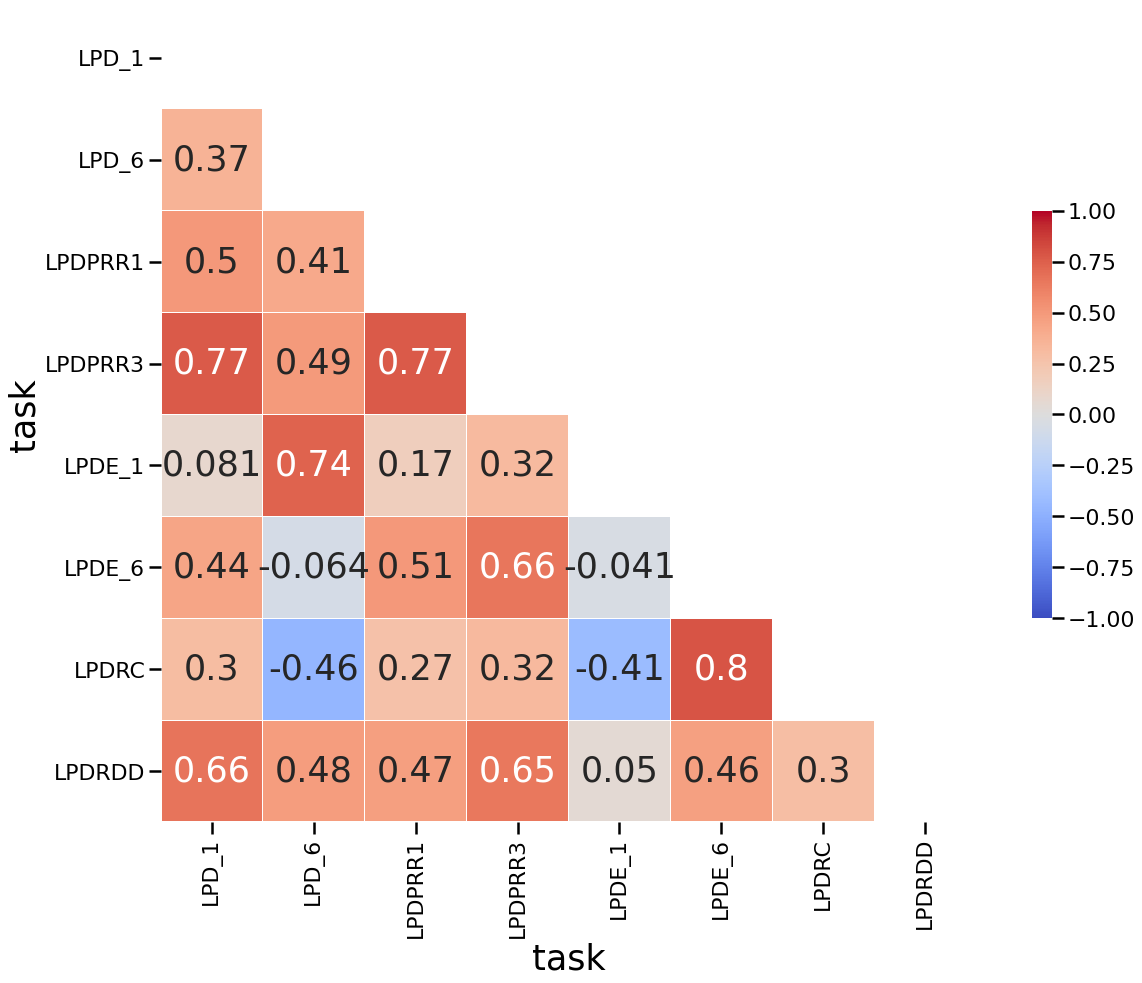

In [122]:
fig, ax = plt.subplots(figsize=(20,15))
corr1 = final_session_data_tidy_melt_wi_16[final_session_data_tidy_melt_wi_16['group']==4][['LPD_1', 'LPD_6', 'LPDPRR1', 'LPDPRR3', 'LPDE_1', 'LPDE_6', 'LPDRC', 'LPDRDD']].corr()
mask = np.triu(np.ones_like(corr1, dtype=bool))
ax = sns.heatmap(corr1, annot=True, vmin=-1, vmax=1, center=0, cmap = 'coolwarm', mask=mask,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()


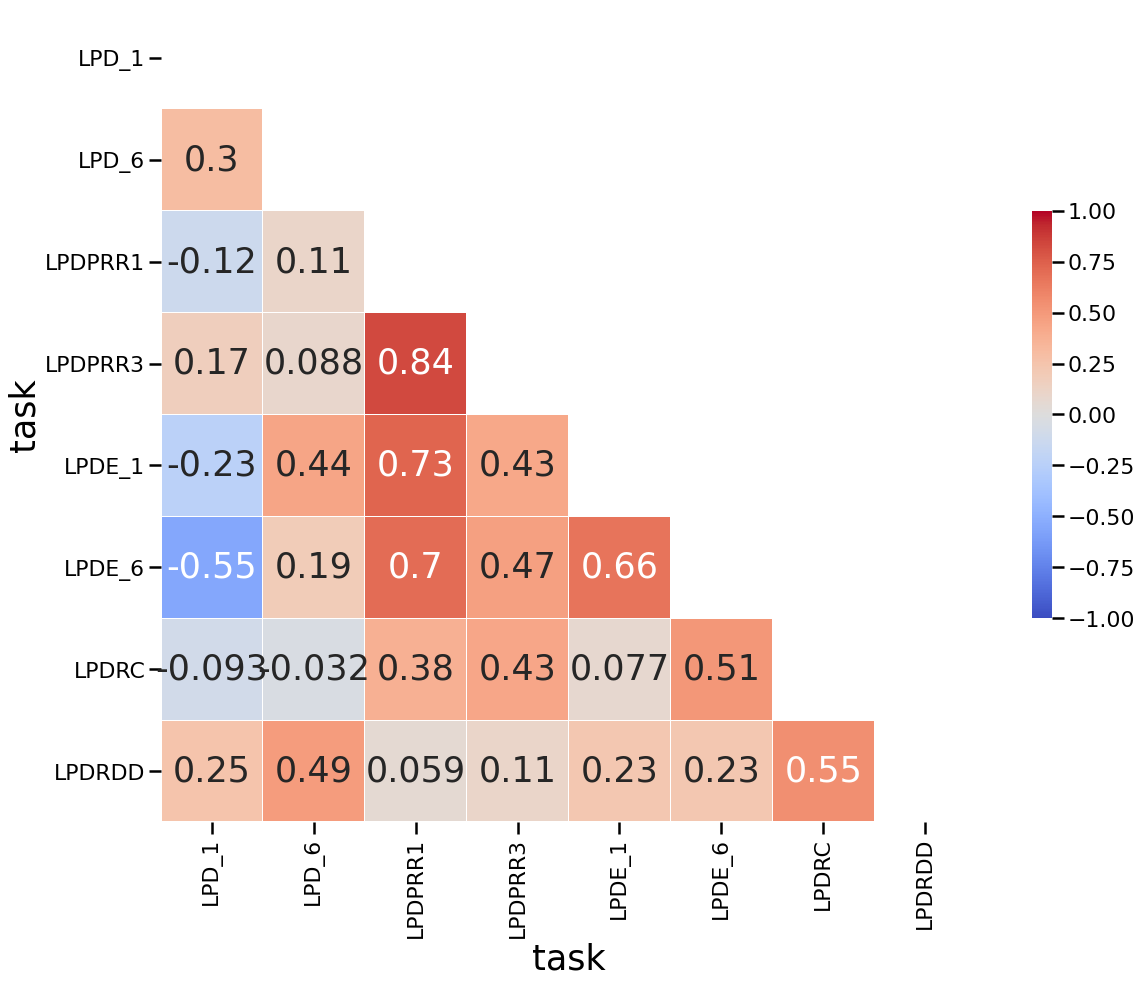

In [123]:
fig, ax = plt.subplots(figsize=(20,15))
corr1 = final_session_data_tidy_melt_wi_16[final_session_data_tidy_melt_wi_16['group']==5][['LPD_1', 'LPD_6', 'LPDPRR1', 'LPDPRR3', 'LPDE_1', 'LPDE_6', 'LPDRC', 'LPDRDD']].corr()
mask = np.triu(np.ones_like(corr1, dtype=bool))
ax = sns.heatmap(corr1, annot=True, vmin=-1, vmax=1, center=0, cmap = 'coolwarm', mask=mask,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()

<AxesSubplot:xlabel='task', ylabel='task'>

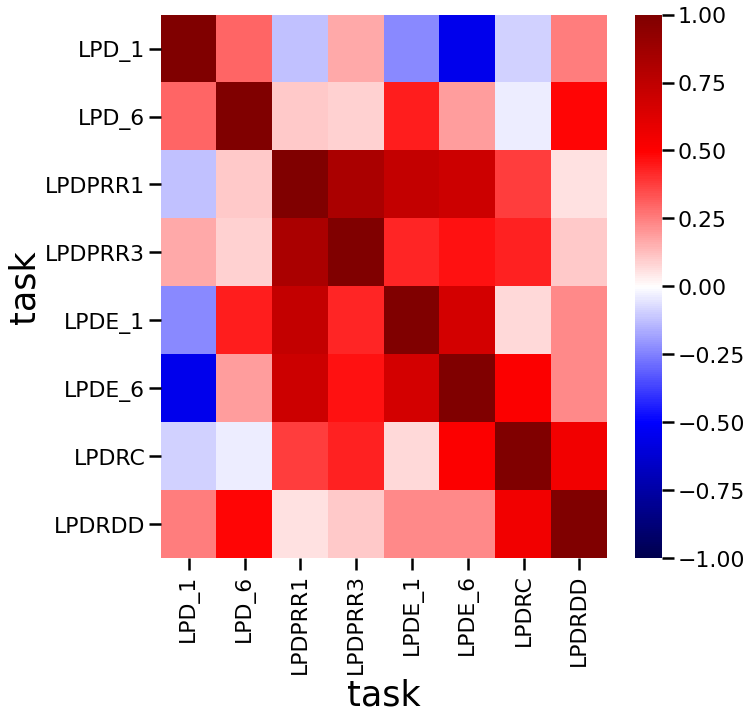

In [112]:
plt.figure(figsize=(10,10))
sns.heatmap(, vmin=-1, vmax=1, cmap='seismic')

In [44]:
#groupby session and trial bin
sum_params = ['reinforcement_count', 'HE_count', 'active_lever_count', 'inactive_lever_count']
final_data_sum = lp_train_df_trial.groupby(['task', 'part', 'session', 'trial_bin', 'date', 'cage', 'animal', 'group', 'active_lever'])[sum_params].sum().reset_index()

mean_params = ['reinforcement_latency_1st', 
               'HE_latency_1st', 'HE_latency_ave', 
               'active_lever_latency_1st', 'inactive_lever_latency_1st', 
               'lever_ratio', 'trial_duration']
final_data_mean = lp_train_df_trial.groupby(['task', 'part', 'session', 'trial_bin', 'date', 'cage', 'animal', 'group', 'active_lever'])[mean_params].mean().reset_index()

final_data_max = lp_train_df_trial.groupby(['task', 'part', 'session', 'trial_bin', 'date', 'cage', 'animal', 'group', 'active_lever'])['trial_num'].max().reset_index()

final_session_trial_data = final_data_sum.merge(final_data_mean, on=['task', 'part', 'session', 'trial_bin', 'date', 'cage', 'animal', 'group', 'active_lever'])
final_session_trial_data['max_trial'] = final_data_max['trial_num']
print(final_session_trial_data.shape)
final_session_trial_data.head()

(6407, 21)


,task,part,session,trial_bin,date,cage,animal,group,active_lever,reinforcement_count,HE_count,active_lever_count,inactive_lever_count,reinforcement_latency_1st,HE_latency_1st,HE_latency_ave,active_lever_latency_1st,inactive_lever_latency_1st,lever_ratio,trial_duration,max_trial
0,LPD,ITI,1,0,200219,SA158,825,4,right,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,29.9998,0
1,LPD,ITI,1,0,200219,SA158,826,4,right,0,0,1,0,NaN,NaN,NaN,0.0699,NaN,1.0,29.9998,0
2,LPD,ITI,1,0,200219,SA158,827,4,right,0,24,1,0,NaN,13.5999,17.780525,0.5799,NaN,1.0,29.9998,1
3,LPD,ITI,1,0,200219,SA159,828,4,left,0,3,0,0,NaN,3.4699,12.979900,NaN,NaN,NaN,29.9998,0
4,LPD,ITI,1,0,200219,SA159,829,4,left,0,0,1,0,NaN,NaN,NaN,0.3099,NaN,1.0,29.9998,0


In [45]:
lp_train_df_trial.to_csv('lp_trials_all.csv', index=False)
final_session_data.to_csv('lp_session_all.csv', index=False)
final_session_trial_data.to_csv('lp_session_trial_all.csv', index=False)

### Viz

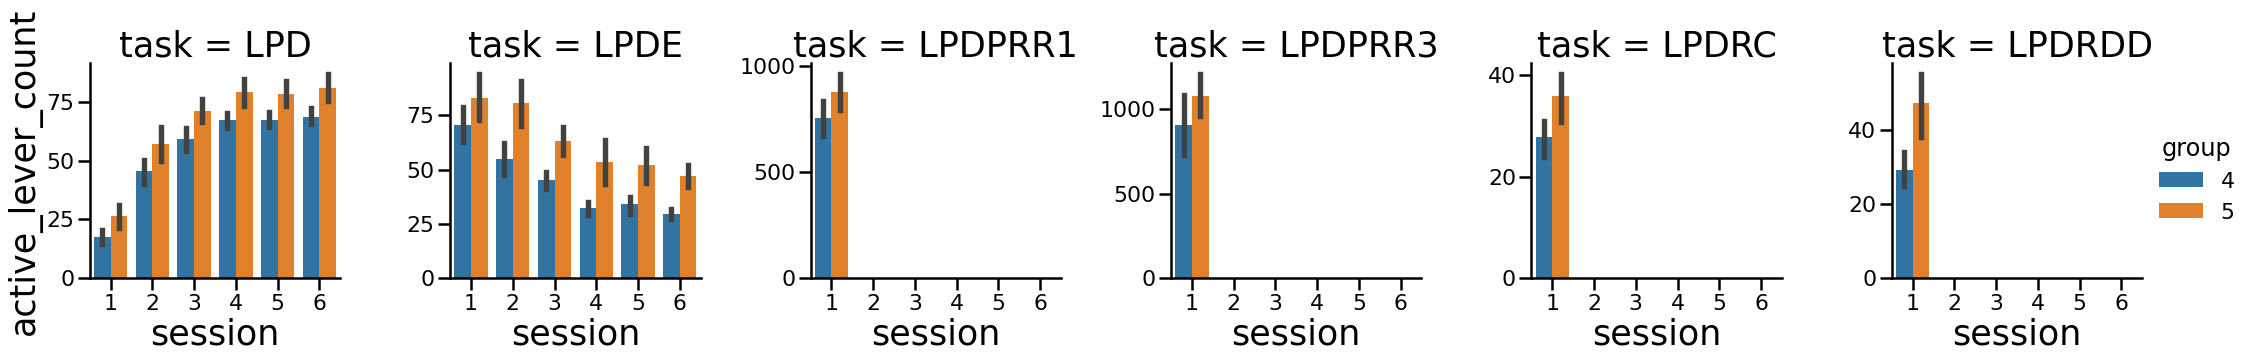

In [54]:
exclude_no_100 = [831] #only 5 aqu sessions
final_session_data_wi = final_session_data[final_session_data['part']=='within']
final_session_data_exclude = final_session_data_wi[~final_session_data_wi['animal'].isin(exclude_no_100)]
sns.catplot(x='session', y='active_lever_count', data=final_session_data_exclude, hue='group', kind='bar', ci=68, col='task', sharey=False)
plt.show()

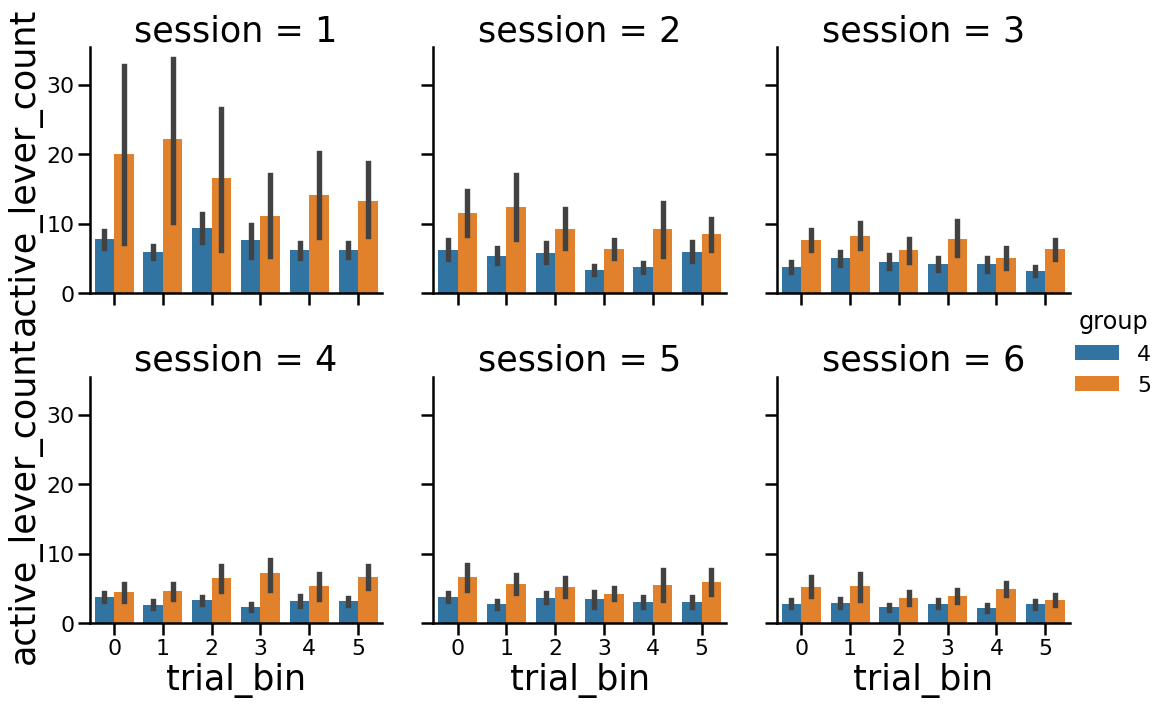

In [60]:
data_int = final_session_trial_data[final_session_trial_data['task'] == 'LPDE']
sns.catplot(x='trial_bin', y='active_lever_count', data=data_int, hue='group', kind='bar', ci=68, col='session', col_wrap=3)
plt.show()

In [38]:
lp_train_df_trial.head()

,task,part,date,session,cage,animal,group,active_lever,trial_num,trial_bin,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_count,HE_latency_1st,HE_latency_ave,active_lever_count,active_lever_latency_1st,inactive_lever_count,inactive_lever_latency_1st,active_lever_latency_ave,inactive_lever_latency_ave,reinforcement_latency_ave,lever_ratio
0,LPDE,within,200318,3,SA161,835,5,right,0,0,118.75,0,NaN,8,100.32,107.30625,0,NaN,1,118.74,NaN,118.74,NaN,0.0
1,LPDE,within,200318,3,SA161,835,5,right,1,0,24.46,0,NaN,1,14.43,14.43000,1,20.24,1,24.45,20.24,24.45,NaN,0.5
2,LPDE,within,200318,3,SA161,835,5,right,2,0,20.55,0,NaN,0,NaN,NaN,0,NaN,1,20.54,NaN,20.54,NaN,0.0
3,LPDE,within,200318,3,SA161,835,5,right,3,0,0.46,0,NaN,0,NaN,NaN,0,NaN,1,0.45,NaN,0.45,NaN,0.0
4,LPDE,within,200318,3,SA161,835,5,right,4,0,27.60,0,NaN,2,25.73,25.78000,1,1.80,1,27.59,1.80,27.59,NaN,0.5


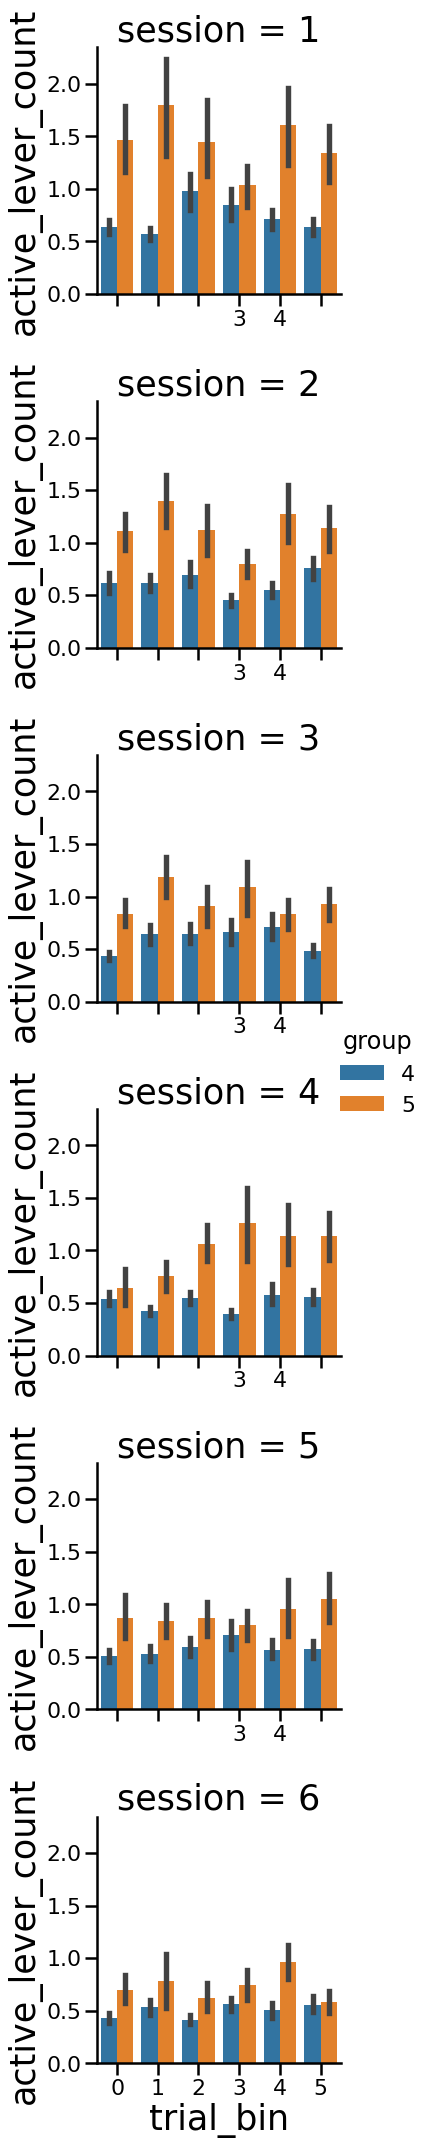

In [40]:
data_int = lp_train_df_trial[lp_train_df_trial['task'] == 'LPDE']
sns.catplot(x='trial_bin', y='active_lever_count', data=data_int, hue='group', kind='bar', ci=68, col='session', col_wrap=1)
plt.show()

In [ ]:
file_path = file_paths[0]
print('file_path:', '\n', file_path, '\n')

task, session, animal, date = get_file_info_common(file_path)
print('date:', date, 'animal:', animal, 'task:', task, 'session:', session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E:", "D:")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_LPD(events_and_times, [46,47], [48,49])
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times, 'within')
print(trial_data.head(), '\n')

ITI_trial_data = create_trial_df(events_and_times, trial_times, 'ITI')
print(ITI_trial_data.head(), '\n')

bit_dic = {'reinforcement': 17, 'right_lever': 4, 'left_lever': 3, 'HE': 7}
session_data = create_session_df(trial_data, bit_dic, 'within')

ITI_dic = {'right_lever': 10, 'left_lever': 11, 'HE': 14}
ITI_data = create_session_df(ITI_trial_data, ITI_dic, 'ITI')